In [1]:
import sys
import os

#####################
# Import of utils.py functions
#####################
# Required to get utils.py and access its functions
notebook_dir = os.path.abspath("")
parent_dir = os.path.abspath(os.path.join(notebook_dir, '..'))
sys.path.append(parent_dir)
sys.path.append('.')
from utils import loadFSL, FSLeyesServer, mkdir_no_exist

#############################
# Loading fsl and freesurfer within Neurodesk
# You can find the list of available other modules by clicking on the "Softwares" tab on the left
#############################
import lmod
await lmod.purge(force=True)
await lmod.load('fsl/6.0.7.4')
await lmod.load('freesurfer/7.4.1')
await lmod.list()

####################
# Setup FSL path
####################
loadFSL()

####################
# DIPY_HOME should be set prior to import of dipy to make sure all downloads point to the right folder
####################
os.environ["DIPY_HOME"] = "/home/jovyan/Data"

###################
# Load other relevant libraries
##################
import fsl.wrappers, statsmodels
from fsl.wrappers import fslmaths
import dipy
import os.path as op
import nibabel as nib
from mne_bids import BIDSPath, read_raw_bids, print_dir_tree, make_report

In [2]:
%gui wx

Gtk-Message: 11:12:01.805: Failed to load module "canberra-gtk-module"


In [3]:
################
# Start FSLeyes (very neat tool to visualize MRI data of all sorts) within Python
################
fsleyesDisplay = FSLeyesServer()
fsleyesDisplay.show()

11:12:06: Debug: Adding duplicate image handler for 'Windows bitmap file'
11:12:06: Debug: Adding duplicate animation handler for '1' type
11:12:06: Debug: Adding duplicate animation handler for '2' type
11:12:06: Debug: Adding duplicate image handler for 'Windows bitmap file'
11:12:06: Debug: Adding duplicate animation handler for '1' type
11:12:06: Debug: Adding duplicate animation handler for '2' type

(ipykernel_launcher.py:442): Gtk-CRITICAL **: 11:12:07.236: gtk_window_resize: assertion 'height > 0' failed


In [4]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tools.sm_exceptions import ConvergenceWarning

In [5]:
# organisation of directory and creation of preprocessing folders
dataset_id = 'subject101410'
subject = '101410' 

sample_path = "/home/jovyan/data"
mkdir_no_exist(sample_path)
bids_root = op.join(sample_path, dataset_id)
deriv_root = op.join(bids_root, 'derivatives')
preproc_root = op.join(bids_root, 'derivatives','preprocessed_data')

mkdir_no_exist(bids_root)

subject_dir = 'sub-{}'.format(subject)



###################
# Create folders relevant for preprocessing.
# In BIDs, ANYTHING we modify must go in the derivatives folder, to keep original files clean in case we make a mistake.
###################
mkdir_no_exist(op.join(bids_root, 'derivatives'))
preproc_root = op.join(bids_root, 'derivatives','preprocessed_data')
mkdir_no_exist(preproc_root)
mkdir_no_exist(op.join(preproc_root, 'sub-101410'))
mkdir_no_exist(op.join(preproc_root, 'sub-101410', 'anat'))
mkdir_no_exist(op.join(preproc_root, 'sub-101410', 'func'))
mkdir_no_exist(op.join(preproc_root, 'sub-101410', 'fmap')) 



In [6]:
print_dir_tree(bids_root, max_depth=5)

|subject101410/
|--- dataset_description.md
|--- task-motor_bold.json
|--- T1w/
|------ T1w.nii.gz
|--- derivatives/
|------ preprocessed_data/
|--------- sub-101410/
|------------ anat/
|--------------- sub-101410_T1w.nii.gz
|--------------- sub-101410_T1w_fast_mixeltype.nii.gz
|--------------- sub-101410_T1w_fast_pve_0.nii.gz
|--------------- sub-101410_T1w_fast_pve_1.nii.gz
|--------------- sub-101410_T1w_fast_pve_2.nii.gz
|--------------- sub-101410_T1w_fast_pveseg.nii.gz
|--------------- sub-101410_T1w_fast_seg.nii.gz
|--------------- sub-101410_T1w_mask.nii.gz
|------------ fmap/
|------------ func/
|--------------- sub-101410_task-motor_concat_varnorm.nii.gz
|--------------- sub-101410_task-motor_concat_varnorm_moco.nii.gz
|--------------- sub-101410_task-motor_concat_varnorm_moco.par
|--------------- sub-101410_task-motor_concat_varnorm_moco_smoothed-6mm.nii.gz
|--------------- sub-101410_task-motor_func2anat.nii.gz
|--------------- tfMRI_MOTOR_LR_varnorm.nii.gz
|--------------

In [18]:
# first get events
# definir les paths
func_path = op.join(bids_root, 'sub-101410', 'func')
mkdir_no_exist(op.join(bids_root, 'sub-001'))
mkdir_no_exist(func_path)

events_LR = op.join(bids_root, "fMRI", "tfMRI_MOTOR_LR", "events_LR.csv")
events_RL = op.join(bids_root, "fMRI", "tfMRI_MOTOR_RL", "events_RL.csv")

# get events data
df_LR = pd.read_csv(events_LR)
df_RL = pd.read_csv(events_RL)

# shift onset for second run so they don't overlap and no duplicates (run1 then run2)
run1_duration = df_LR['onset'].iloc[-1] + df_LR['duration'].iloc[-1]
df_RL['onset'] += run1_duration

# combine them
events = pd.concat([df_LR, df_RL], ignore_index=True)


# renaming for FirstLevelModel
events = events.rename(columns={'condition': 'trial_type'})

events

,onset,duration,trial_type
0,0.0,8.0,NaN
1,8.0,3.0,cue
2,11.0,12.0,rh
3,23.0,3.0,cue
4,26.0,12.0,lf
5,38.0,3.0,cue
6,41.0,12.0,t
7,53.0,3.0,cue
8,56.0,12.0,rf
9,68.0,3.0,cue


In [10]:
# get preprocessed fMRI image

smoothed_path = op.join(preproc_root, "sub-101410", "func", "sub-101410_task-motor_concat_varnorm_moco_smoothed-6mm.nii.gz")
fmri_img = nib.load(smoothed_path)


In [19]:
# create basic design matrix, IS IT GOOD ? ASK TA's
from nilearn.glm.first_level import make_first_level_design_matrix, FirstLevelModel

# Specify what sort of GLM we want (nature of the noise, repetition time of the data and other parameters)
fmri_glm = FirstLevelModel(t_r=0.72, # from the .json file
                           noise_model='ar1',
                           standardize=False,
                           hrf_model='spm',
                           drift_model=None,
                           high_pass=.01)

# Fit the model to our design and data
fmri_glm = fmri_glm.fit(fmri_img, events)

/opt/conda/lib/python3.11/site-packages/nilearn/glm/first_level/experimental_paradigm.py:198: UserWarning: Duplicated events were detected. Amplitudes of these events will be summed. You might want to verify your inputs.
  warnings.warn(


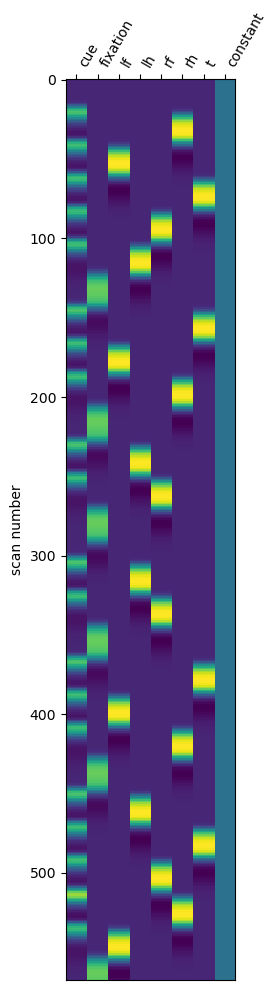

In [20]:
from nilearn.plotting import plot_design_matrix
import matplotlib.pyplot as plt

plot_design_matrix(fmri_glm.design_matrices_[0])
plt.show()

In [36]:
# run GLM, and make statistical maps (for each task)

# Create the dictionary of the conditions

conditions = {
    'cue': np.array([1, 0, 0, 0, 0, 0, 0 ,0]), 
    'fixation':np.array([0, 1, 0, 0, 0, 0, 0, 0]),
    'lf': np.array([0, 0, 1, 0, 0, 0, 0 ,0]), 
    'lh':np.array([0, 0, 0, 1, 0, 0, 0, 0]),
    'rf': np.array([0, 0, 0, 0, 1, 0, 0 ,0]), 
    'rh':np.array([0, 0, 0, 0, 0, 1, 0, 0]),
    't': np.array([0, 0, 0, 0, 0, 0, 1 ,0])
}


In [37]:
# get contrast maps
from nilearn.glm import threshold_stats_img

z_map_lf = fmri_glm.compute_contrast(conditions['lf'],
                                  output_type='z_score')
z_map_lh = fmri_glm.compute_contrast(conditions['lh'],
                                  output_type='z_score')
z_map_rf = fmri_glm.compute_contrast(conditions['rf'],
                                  output_type='z_score')
z_map_rh = fmri_glm.compute_contrast(conditions['rh'],
                                  output_type='z_score')
z_map_t = fmri_glm.compute_contrast(conditions['t'],
                                  output_type='z_score')

# multiple-comparisons : to avoid false positives
cluster_size = 10 
fdr_rate = 0.05

# Here, we apply the FDR correction + threshold
clean_map_lf, threshold_lf = threshold_stats_img(z_map_lf, alpha=fdr_rate, height_control='fdr', cluster_threshold=cluster_size)
clean_map_lh, threshold_lh = threshold_stats_img(z_map_lh, alpha=fdr_rate, height_control='fdr', cluster_threshold=cluster_size)
clean_map_rf, threshold_rf = threshold_stats_img(z_map_rf, alpha=fdr_rate, height_control='fdr', cluster_threshold=cluster_size)
clean_map_rh, threshold_rh = threshold_stats_img(z_map_rh, alpha=fdr_rate, height_control='fdr', cluster_threshold=cluster_size)
clean_map_t, threshold_t = threshold_stats_img(z_map_t, alpha=fdr_rate, height_control='fdr', cluster_threshold=cluster_size)


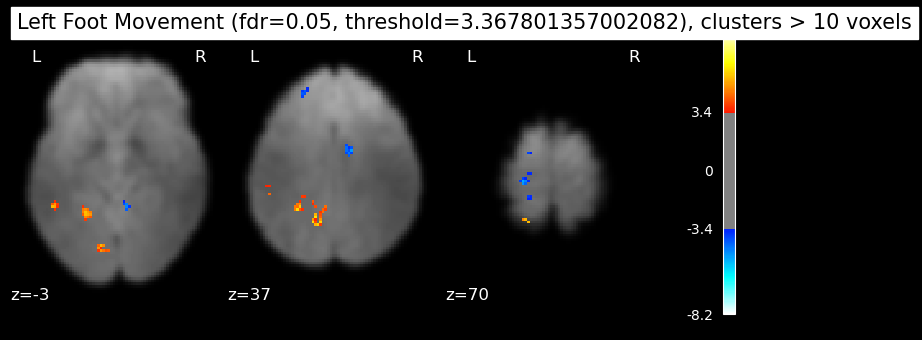

In [44]:
# statistical map plots, A REVOIR LES RESULTS FONT PAS TROP DE SENS 
from nilearn.plotting import plot_stat_map
from nilearn.image import mean_img

mean_img_ = mean_img(fmri_img)

plot_stat_map(clean_map_lf, bg_img=mean_img_, threshold=threshold_lf,
              display_mode='z', cut_coords=[-3,37,70], black_bg=True,
              title='Left Foot Movement (fdr={}, threshold={}), clusters > {} voxels'.format(fdr_rate, threshold_lf, cluster_size))
plt.show()


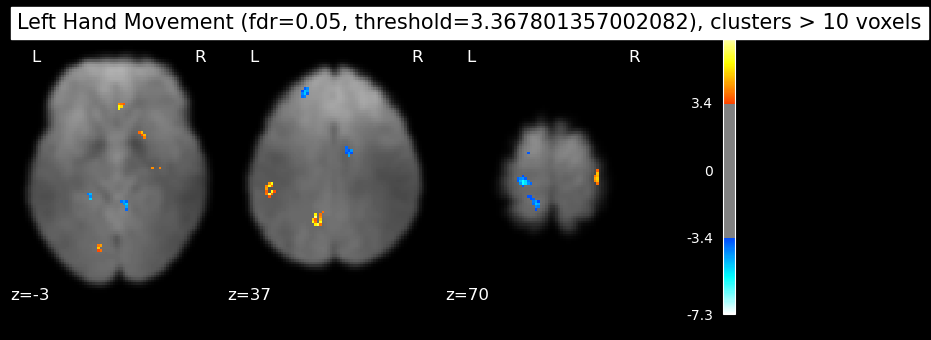

In [39]:
plot_stat_map(clean_map_lh, bg_img=mean_img_, threshold=threshold_lh,
              display_mode='z', cut_coords=[-3,37,70], black_bg=True,
              title='Left Hand Movement (fdr={}, threshold={}), clusters > {} voxels'.format(fdr_rate, threshold_lf, cluster_size))
plt.show()

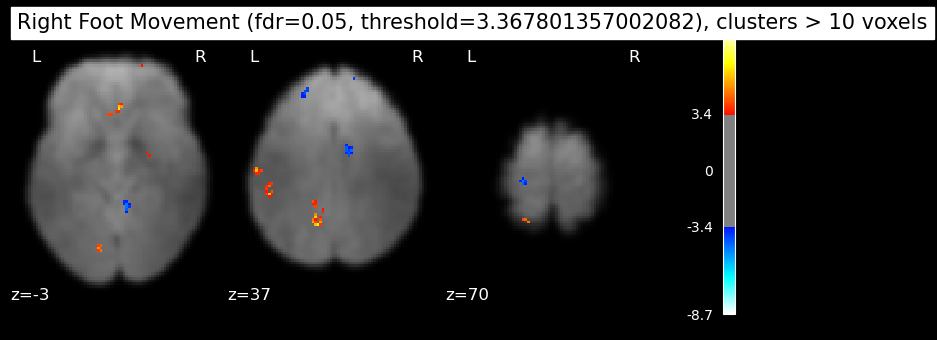

In [40]:
plot_stat_map(clean_map_rf, bg_img=mean_img_, threshold=threshold_rf,
              display_mode='z', cut_coords=[-3,37,70], black_bg=True,
              title='Right Foot Movement (fdr={}, threshold={}), clusters > {} voxels'.format(fdr_rate, threshold_lf, cluster_size))
plt.show()

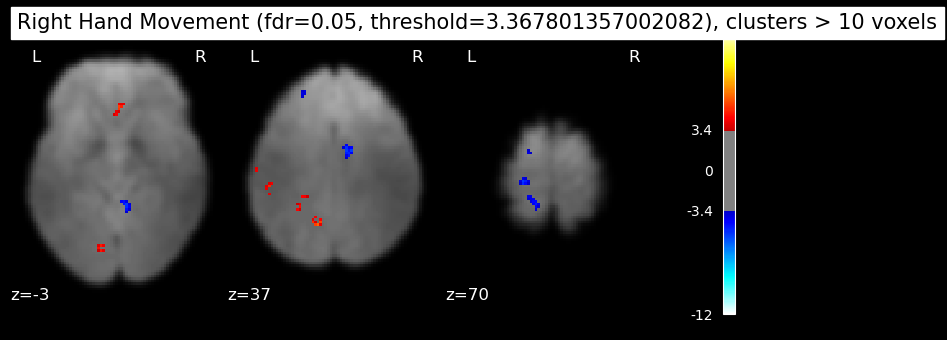

In [41]:
plot_stat_map(clean_map_rh, bg_img=mean_img_, threshold=threshold_rh,
              display_mode='z', cut_coords=[-3,37,70], black_bg=True,
              title='Right Hand Movement (fdr={}, threshold={}), clusters > {} voxels'.format(fdr_rate, threshold_lf, cluster_size))
plt.show()

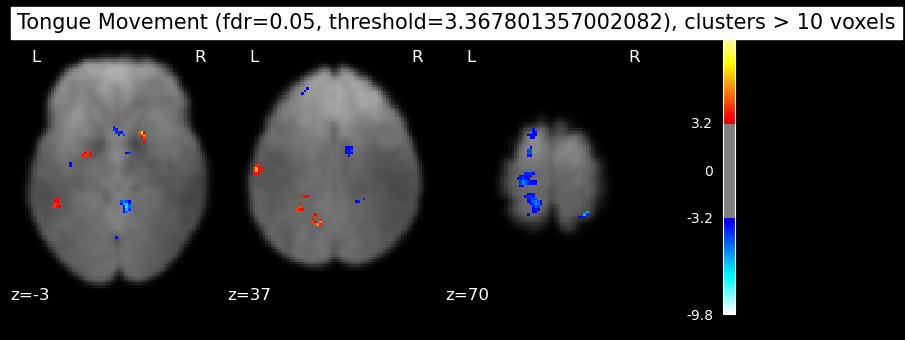

In [42]:
plot_stat_map(clean_map_t, bg_img=mean_img_, threshold=threshold_t,
              display_mode='z', cut_coords=[-3,37,70], black_bg=True,
              title='Tongue Movement (fdr={}, threshold={}), clusters > {} voxels'.format(fdr_rate, threshold_lf, cluster_size))
plt.show()